# INTERPRETABILITY RESULTS

In [10]:

from data import UKDALEData,HOSPData
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from modelGen import modelGen
from address import get_model_path
from models.utils import oneHot

%matplotlib inline



In [2]:
# Data
dataGen = UKDALEData(path="./data/")
trainMain,trainTargets, trainStates = dataGen.get_train_sequences(houses = 1,
                                                                  start = "2015-01-01",
                                                                  end="2016-01-01")
testMain,testTargets, testStates = dataGen.get_test_sequences(houses = 1,
                                                              start = "2016-01-01",
                                                              end="2016-02-01",
                                                              norm=False)


dataUK= {"X_train":trainMain,
        "Y_train":trainTargets,
        "Y_states":trainStates,
        "Z_train":trainStates,
        "X_test":testMain,
        "Y_test":testTargets,
        "Z_test":testStates,
        "app_data":dataGen.get_app_data(),
        "main_data": dataGen.get_main_mean_std()
        } 


## UK-DALE results

In [3]:

MODELSID = "multiFCNdAE"
APP_LABELS = list(dataUK["app_data"].keys())
MODELS = []
WEIGHTS = []
TIMES   = []
n = 10 # Number of inferences to compute the averaged inference time

model = modelGen(modelID=MODELSID,data=dataUK)
model.load(get_model_path("UKDALE",MODELSID))



Building model
loading best hyperparameters
FCNdAE
multiFCNdAE
Building model: <bound method multiFCNdAE.get_model_name of <class 'models.multiFCNdAE.multiFCNdAE'>> [<bound method multiFCNdAE.get_model_type of <class 'models.multiFCNdAE.multiFCNdAE'>>]
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mod_input (InputLayer)         [(None, 5)]          0           []                               
                                                                                                  
 FiLM_GEN_1 (Dense)             (None, 32)           192         ['mod_input[0][0]']              
                                                                                                  
 FiLM_GEN_act_1 (LeakyReLU)     (None, 32)           0           ['FiLM_GEN_1[0][0]']             
                                       

2023-12-14 20:18:36.564571: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-14 20:18:36.812050: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22311 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


restoring weights of model multiFCNdAE from path: /home/diego/repositorios/NCA23_nilm/results/UKDALE/multiFCNdAE/multiFCNdAE


In [4]:
# Getting latent space activations
X = dataUK["X_test"][:10*60*24*7] # 1-week seq
z,SD = model.predict_z(X)
y    = model.predict(X)
SD   = np.argmax(SD,axis=1)


2023-12-14 20:18:37.837535: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-14 20:18:38.147250: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


21/21 [==============================] - 0s 16ms/step


In [7]:
# Projection latent space activations
import umap

#z_ = (z-np.mean(z,axis=1,keepdims=True))/np.std(z,axis=1,keepdims=True)
reducer = umap.UMAP(min_dist=0.1,n_neighbors=200,verbose=True)
reducer.fit(z)
embeddigns = reducer.transform(z)

UMAP(n_neighbors=200, verbose=True)
Tue Dec 12 21:32:45 2023 Construct fuzzy simplicial set
Tue Dec 12 21:32:45 2023 Finding Nearest Neighbors
Tue Dec 12 21:32:45 2023 Building RP forest with 16 trees
Tue Dec 12 21:32:46 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Tue Dec 12 21:33:12 2023 Finished Nearest Neighbor Search
Tue Dec 12 21:33:14 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Dec 12 21:33:33 2023 Finished embedding


Text(0.5, 1.0, '$z$ for UK-DALE data')

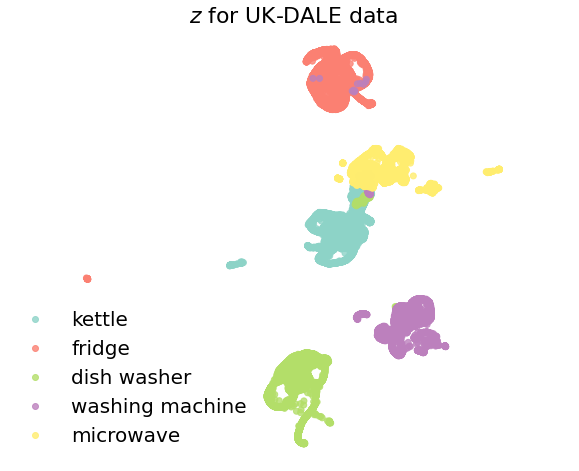

In [8]:
%matplotlib inline
# Fig latent space
cmap = plt.cm.get_cmap("Set3",len(APP_LABELS))
plt.figure("UK_LS",figsize=(10,8))
ax = plt.subplot(111)
sctt = plt.scatter(embeddigns[:,0],embeddigns[:,1],alpha=0.8,c=SD,cmap=cmap)
ax.axis("equal")
ax.axis("off")
leg_ticks = sctt.legend_elements()[0]
legend1 = ax.legend(leg_ticks,APP_LABELS,
                    loc="lower left",
                    bbox_to_anchor=(-0.03,0),
                    frameon=False,fontsize=20)
ax.set_title(r"$z$ for UK-DALE data",fontdict={"fontsize":22})

## TRANSITIONS


In [4]:
# Selecting a window where two different appliance appears together
X = dataUK["X_test"]
Y = dataUK["Y_test"]
Z = dataUK["Z_test"]
APP1_ID = APP_LABELS.index("washing machine")
APP2_ID = APP_LABELS.index("microwave")

idx = np.intersect1d(np.argwhere(Z[APP1_ID]==1).ravel(),np.argwhere(Z[APP2_ID]==1).ravel())
idx = np.random.permutation(idx)[0]
L = 500
X_w = X[idx-L:idx+L]
APP1_w = Y[APP1_ID][idx-L:idx+L]
APP2_w = Y[APP2_ID][idx-L:idx+L]

Y_est = model.predict(X_w)


2023-12-13 03:06:42.348122: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-13 03:06:42.653799: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


1/1 [==============================] - 0s 12ms/step


In [5]:


# Predicting the transitions
sd_start = oneHot([APP1_ID],len(APP_LABELS))
sd_end = oneHot([APP2_ID],len(APP_LABELS))
N_t = 5
alpha = np.linspace(0,1,N_t).reshape(-1,1)
SD = sd_start +(sd_end-sd_start)*alpha

transitions = model.predict_transition(X_w,SD)

1/1 [==============================] - 0s 11ms/step


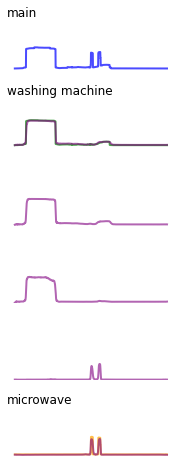

: 

In [31]:
#Plotting transitions

plt.figure("Transitions",figsize=(3,8))
for i in range(1,N_t-1,1):
    ax = plt.subplot(N_t+1,1,i+2)
    plt.plot(transitions[i],c="purple",linewidth=2,alpha=0.6,label=f"transitions")
    # if i ==N_t//2:
    #     plt.legend(frameon=False,fontsize=12,loc=(0., 0.6),ncol = 2)
    plt.ylim(-100,4000)
    ax.axis("off")
    # ax.spines["top"].set_visible(False)
    # ax.spines["right"].set_visible(False)
    # ax.spines["bottom"].set_visible(False)
    # ax.spines["left"].set_visible(False)
    # ax.set_xticklabels([])
    # ax.set_yticklabels([])
    
    

ax=plt.subplot(N_t+1,1,1)
plt.plot(X_w,c="blue",linewidth=2,alpha=0.7,label= "main")
plt.ylim(-300,5000)
# ax.spines["top"].set_visible(False)
# ax.spines["right"].set_visible(False)
ax.axis("off")
#plt.legend(frameon=False,fontsize=12,loc=(0., 0.7))
ax.set_title("main",fontdict={"fontsize":12},loc='left')

ax=plt.subplot(N_t+1,1,2)
plt.plot(APP1_w,c="green",linewidth=2,alpha=0.7,label=f"{APP_LABELS[APP1_ID]}")
plt.plot(transitions[0],c="purple",linewidth=2,alpha=0.6)
plt.ylim(-300,4000)
# ax.spines["top"].set_visible(False)
# ax.spines["right"].set_visible(False)
ax.axis("off")
#plt.legend(frameon=False,fontsize=12,loc=(0., 0.6),ncol = 2)
ax.set_title(f"{APP_LABELS[APP1_ID]}",fontdict={"fontsize":12},loc='left')


ax=plt.subplot(N_t+1,1,N_t+1)
plt.plot(APP2_w,c="orange",linewidth=2,alpha=0.7,label=f"{APP_LABELS[APP2_ID]}")
plt.plot(transitions[-1],c="purple",linewidth=2,alpha=0.6)
plt.ylim(-300,4000)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
#ax.set_xlabel(f"{APP_LABELS[APP2_ID]}")
#plt.legend(frameon=False,fontsize=12,loc=(0, -0.5))
ax.set_title(f"{APP_LABELS[APP2_ID]}",fontdict={"fontsize":12},loc='left')
plt.subplots_adjust(hspace=0.6)

## Intermediate activations

In [11]:
X = dataUK["X_test"]
Y = dataUK["Y_test"]
Z = dataUK["Z_test"]

APP1_ID = APP_LABELS.index("dish washer")
APP2_ID = APP_LABELS.index("microwave")

idx = np.intersect1d(np.argwhere(Z[APP1_ID]==1).ravel(),np.argwhere(Z[APP2_ID]==1).ravel())
idx = np.random.permutation(idx)[0]
L = 300
X_w = X[idx-L:idx+L]
APP1_w = Y[APP1_ID][idx-L:idx+L]
APP2_w = Y[APP2_ID][idx-L:idx+L]

sd_start = oneHot([APP1_ID],len(APP_LABELS))
sd_end = oneHot([APP2_ID],len(APP_LABELS))
N_t = 5
alpha = np.linspace(0,1,2).reshape(-1,1)
SD = sd_start +(sd_end-sd_start)*alpha





In [14]:
F,GAMMAS = model.get_intermediate_activations(X_w,
                                              SD,
                                              layers=["Enc_conv0_1","FiLM_GEN_params_conv1_1"])



1/1 [==============================] - 0s 11ms/step


<Figure size 1152x648 with 0 Axes>

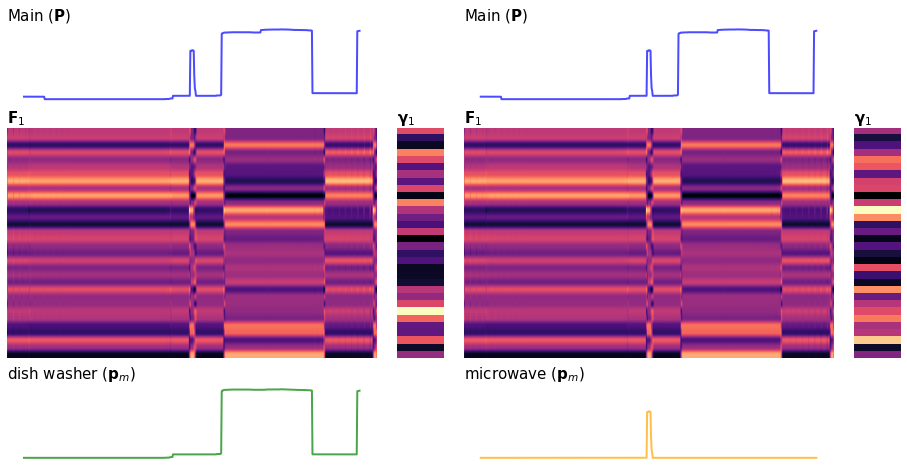

In [24]:
plt.figure("Intermediate activations",figsize=(16,9))

fig, ax = plt.subplots(3, 4, gridspec_kw={'width_ratios': [8, 1,8,1],'height_ratios': [0.5,1.5,0.5]},
                            figsize=(16,8))

# Main

ax[0,0].plot(X_w,c="blue",linewidth=2,alpha=0.7,label= "Main")
ax[0,0].axis("off")
#ax[0,0].legend(frameon=False,fontsize=15)
ax[0,0].set_title(r"Main $(\mathbf{P})$",fontdict={"fontsize":15},loc='left')
# Main
#plt.subplot(3,4,3)
ax[0,2].plot(X_w,c="blue",linewidth=2,alpha=0.7,label= "Main")
ax[0,2].set_title(r"Main $(\mathbf{P})$",fontdict={"fontsize":15},loc='left')
ax[0,2].axis("off")

# Act
#plt.subplot(3,4,5)
alphas = (GAMMAS[0] - GAMMAS[0].min())/(GAMMAS[0].max()-GAMMAS[0].min())*0.3 + 0.7
alphas = alphas.reshape((-1,1))
alphas = np.tile(alphas, (1,F[0].shape[0]))
ax[1,0].imshow(F[0].T,cmap= plt.cm.get_cmap("magma"), aspect='auto',interpolation=None)
ax[1,0].axis("off")
ax[1,0].set_title(r"$\mathbf{F}_1$",fontdict={"fontsize":15},loc='left')
# Gamma
#plt.subplot(3,4,6)
ax[1,1].imshow(GAMMAS[0].reshape(-1,1),cmap= plt.cm.get_cmap("magma"),aspect='auto',interpolation=None)
ax[1,1].axis("off")
ax[1,1].set_title(r"$\mathbf{\gamma}_1$",fontdict={"fontsize":15},loc='left')
# Act
#plt.subplot(3,4,7)
alphas = (GAMMAS[1] - GAMMAS[1].min())/(GAMMAS[1].max()-GAMMAS[1].min())*0.3 + 0.7
alphas = alphas.reshape((-1,1))
alphas = np.tile(alphas, (1,F[0].shape[0]))
ax[1,2].imshow(F[1].T,cmap= plt.cm.get_cmap("magma"),aspect='auto',interpolation=None)
ax[1,2].axis("off")
ax[1,2].set_title(r"$\mathbf{F}_1$",fontdict={"fontsize":15},loc='left')
# Gamma
#plt.subplot(3,4,8)
ax[1,3].imshow(GAMMAS[1].reshape(-1,1),cmap= plt.cm.get_cmap("magma"),aspect='auto',interpolation=None)
ax[1,3].axis("off")
ax[1,3].set_title(r"$\mathbf{\gamma}_1$",fontdict={"fontsize":15},loc='left')
# Apps
#plt.subplot(3,4,9)
ax[2,0].plot(APP1_w,c="green",linewidth=2,alpha=0.7,label=f"{APP_LABELS[APP1_ID]}")
ax[2,0].set_ylim(-100,2500)
#ax[2,0].legend()
ax[2,0].axis("off")
ax[2,0].set_title(r"%s $(\mathbf{p}_m$)"%APP_LABELS[APP1_ID],fontdict={"fontsize":15},loc='left')

#plt.subplot(3,4,11)
ax[2,2].plot(APP2_w,c="orange",linewidth=2,alpha=0.7,label=f"{APP_LABELS[APP2_ID]}")
#ax[2,2].legend()
ax[2,2].axis("off")
ax[2,2].set_ylim(-100,2500)
ax[2,2].set_title(r"%s $(\mathbf{p}_m$)"%APP_LABELS[APP2_ID],fontdict={"fontsize":15},loc='left')

fig.delaxes(ax[0,1])
fig.delaxes(ax[0,3])
fig.delaxes(ax[2,1])
fig.delaxes(ax[2,3])
fig.subplots_adjust(wspace=0.1)